In [1]:
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.Random import get_random_bytes

def hybrid_rsa_aes_encryption(data, public_key):
    # Generate a random AES key
    aes_key = get_random_bytes(16)

    # Encrypt the data with AES
    cipher_aes = AES.new(aes_key, AES.MODE_EAX)
    ciphertext, tag = cipher_aes.encrypt_and_digest(data)

    # Encrypt the AES key with RSA
    cipher_rsa = PKCS1_OAEP.new(public_key)
    cipher_key = cipher_rsa.encrypt(aes_key)

    return (ciphertext, tag, cipher_aes.nonce, cipher_key)

def hybrid_rsa_aes_decryption(ciphertext, tag, nonce, cipher_key, private_key):
    # Decrypt the AES key with RSA
    cipher_rsa = PKCS1_OAEP.new(private_key)
    aes_key = cipher_rsa.decrypt(cipher_key)

    # Decrypt the data with AES
    cipher_aes = AES.new(aes_key, AES.MODE_EAX, nonce=nonce)
    data = cipher_aes.decrypt_and_verify(ciphertext, tag)

    return data


In [2]:
import random
import time
import threading
import pandas as pd
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA

private_key = RSA.generate(2048)
public_key = private_key.publickey()

class Sensor:
    def __init__(self, sensor_id):
        self.sensor_id = sensor_id

    def generate_message(self):
        timestamp = time.time()
        data = random.randint(1, 100)
        return {'sensor_id': self.sensor_id, 'timestamp': timestamp, 'data': data, 'send_timestamp': timestamp}

    def encrypt_message(self):
        message = self.generate_message()
        serialized_message = str(message).encode('utf-8')
        encrypted_message = hybrid_rsa_aes_encryption(serialized_message, public_key)
        return encrypted_message

class Attacker:
    def __init__(self, attacker_id, servers):
        self.attacker_id = attacker_id
        self.servers = servers

    def intercept_message(self, message, sender):
        # The attacker intercepts the message
        intercepted_message = message
        # The attacker waits for 15 seconds before resending the intercepted message
        time.sleep(1.5)
        # The attacker resends the intercepted message to a random server
        target_server = random.choice(self.servers)
        target_server.process_message(intercepted_message, f"Attacker {self.attacker_id}")

class Server:
    def __init__(self, server_id, private_key):
        self.server_id = server_id
        self.private_key = private_key
        self.received_messages = set()
        self.successful_messages = 0
        self.successful_attacks = 0
        self.successful_attacks_dropped = 0
        self.start_time = time.time()
        self.end_time = None
        self.processing_units_used = 0 
        self.processed_messages = 0  
        self.latest_timestamp = 0
        self.successful_attacks_detected = 0
        self.processing_times = []

    def process_message(self, message, sender):
        start_time = time.time()
        decrypted_message = hybrid_rsa_aes_decryption(*message, self.private_key)
        original_message = decrypted_message.decode('utf-8')
        message_content = eval(original_message)
        
        timestamp = message_content['timestamp']
        if (timestamp, sender) not in self.received_messages:
            self.received_messages.add((timestamp, sender))
            self.successful_messages += 1

            if "Attacker" in sender:
                self.successful_attacks += 1

            if self.server_id == 1 and "Attacker" in sender:
                self.successful_attacks_dropped += 1
                if self.detect_attack(timestamp):
                    self.successful_attacks_detected += 1

            else:
                self.processed_messages += 1
                self.processing_units_used += 0.2
                print(f"Server {self.server_id} received: {original_message} from {sender}")
        
        end_time = time.time()  # End timing the processing
        processing_time = (end_time - start_time) * 1000  # Convert to milliseconds
        self.processing_times.append(processing_time)

    def detect_attack(self, timestamp):
        # Detect potential replay attacks by checking if the timestamp is significantly older than the latest timestamp
        current_time = time.time()
        if current_time - timestamp > 1:  # Threshold of 1 seconds to consider it an attack
            return True
        return False
    
    def calculate_average_processing_time(self):
        if self.processed_messages > 0:
            return sum(self.processing_times) / len(self.processing_times)
        return 0

    def calculate_resource_utilization(self):
        return self.processing_units_used

def simulate_sensor(sensor, servers, attackers, interception_probability):
    for _ in range(100):
        target_server = random.choice(servers)
        encrypted_message = sensor.encrypt_message()
        print(f"Sensor {sensor.sensor_id} sending: {encrypted_message}")

        if random.random() < interception_probability:  # Dynamic interception chance
            attacker = random.choice(attackers)
            attacker.intercept_message(encrypted_message, f"Sensor {sensor.sensor_id}")
        else:
            target_server.process_message(encrypted_message, f"Sensor {sensor.sensor_id}")


def compile_metrics_to_dataframe(servers, interception_probability):
    # Initialize an empty list to hold the data for each server
    data = []

    # Compile metrics for each server
    for server in servers:
        resource_utilization = server.calculate_resource_utilization()
        average_processing_time = server.calculate_average_processing_time()
        detection_rate = server.successful_attacks_detected / server.successful_attacks * 100 if server.successful_attacks > 0 else 0
        
        # Add the server's metrics to the data list
        data.append({
            'Interception Probability': interception_probability,
            'Server ID': server.server_id,
            'Processed Messages': server.processed_messages,
            'Successful Attacks': server.successful_attacks,
            'Attacks Dropped': server.successful_attacks_dropped,
            'Resource Utilization': f"{resource_utilization:.2f}",
            'Average Processing Time (ms)': f"{average_processing_time:.2f}",
            'Detection Rate': f"{detection_rate:.2f},%"
        })

    # Convert the list of data into a pandas DataFrame
    return pd.DataFrame(data)

def main():
    interception_probabilities = [0.1, 0.2, 0.3, 0.4, 0.5]
    metrics_list = []  # Collect data as a list of dictionaries

    for interception_probability in interception_probabilities:
        # Initialize or reset sensors, servers, and attackers for each probability run
        sensors = [Sensor(sensor_id) for sensor_id in range(1, 51)]
        servers = [Server(server_id, private_key) for server_id in range(1, 3)]
        attackers = [Attacker(attacker_id, servers) for attacker_id in range(1, 6)]
        
        threads = []
        for sensor in sensors:
            thread = threading.Thread(target=simulate_sensor, args=(sensor, servers, attackers, interception_probability))
            threads.append(thread)
            thread.start()
        
        for thread in threads:
            thread.join()
        
        # Compile metrics for this interception probability
        metrics_df = compile_metrics_to_dataframe(servers, interception_probability)
        
        # Convert each row in the metrics DataFrame to a dictionary and add it to the list
        for _, row in metrics_df.iterrows():
            metrics_list.append(row.to_dict())
    
    # Convert the list of dictionaries to a DataFrame
    final_metrics_df = pd.DataFrame(metrics_list)
    
    
    # Display the final DataFrame
    final_metrics_df.to_csv('performance_metrics.csv')

if __name__ == "__main__":
    main()

In [3]:
metrics_table = pd.read_csv('performance_metrics.csv')
metrics_table

,Unnamed: 0,Interception Probability,Server ID,Processed Messages,Successful Attacks,Attacks Dropped,Resource Utilization,Average Processing Time (ms),Detection Rate
0,0,0.1,1,2279,262,262,455.8,47.12,"100.00,%"
1,1,0.1,2,2459,259,0,491.8,46.95,"0.00,%"
2,2,0.2,1,1991,484,484,398.2,15.39,"100.00,%"
3,3,0.2,2,2525,513,0,505.0,16.03,"0.00,%"
4,4,0.3,1,1760,769,769,352.0,10.56,"100.00,%"
5,5,0.3,2,2470,736,0,494.0,10.64,"0.00,%"
6,6,0.4,1,1547,975,975,309.4,12.13,"100.00,%"
7,7,0.4,2,2478,981,0,495.6,12.19,"0.00,%"
8,8,0.5,1,1223,1259,1259,244.6,13.39,"100.00,%"
9,9,0.5,2,2511,1243,0,502.2,13.16,"0.00,%"


['C:\\Users\\YANSILIYU\\devProject\\replay\\processed_messages.png',
 'C:\\Users\\YANSILIYU\\devProject\\replay\\successful_attacks.png',
 'C:\\Users\\YANSILIYU\\devProject\\replay\\attacks_dropped.png',
 'C:\\Users\\YANSILIYU\\devProject\\replay\\resource_utilization.png',
 'C:\\Users\\YANSILIYU\\devProject\\replay\\average_processing_time_(ms).png',
 'C:\\Users\\YANSILIYU\\devProject\\replay\\detection_rate.png']

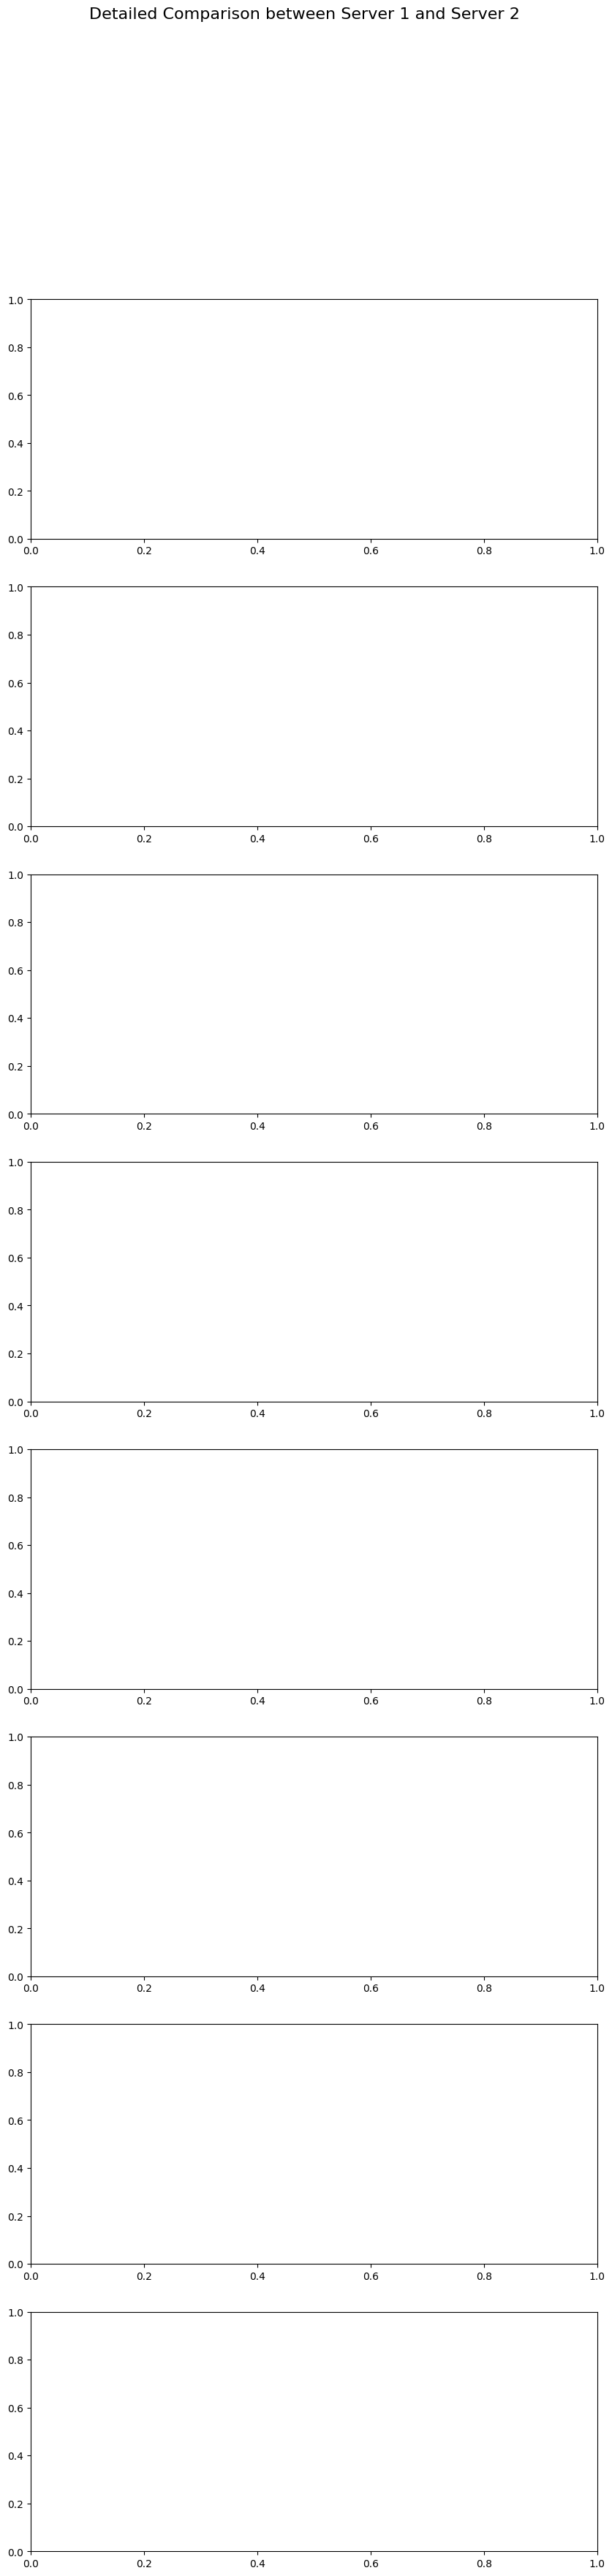

In [7]:
# Define path for saving images
save_path = 'C:\\Users\\YANSILIYU\\devProject\\replay\\'

# Filtering data by Server ID
server1 = metrics_table[metrics_table['Server ID'] == 1]
server2 = metrics_table[metrics_table['Server ID'] == 2]

# Setting up figure dimensions
fig, axes = plt.subplots(8, 1, figsize=(10, 40))
fig.suptitle('Detailed Comparison between Server 1 and Server 2', fontsize=16)

metrics = [
    'Processed Messages', 'Successful Attacks', 
    'Attacks Dropped', 'Resource Utilization', 
    'Average Processing Time (ms)', 'Detection Rate'
]

# Plotting and saving individual graphs
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(server1['Interception Probability'], server1[metric], label='Server with TimeStamp Detection Mechanism')
    ax.plot(server2['Interception Probability'], server2[metric], linestyle='--', label='Server without TimeStamp Detection Mechanism')
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Interception Probability')
    ax.set_ylabel(metric)
    ax.legend()
    # Save each plot as a separate file
    file_path = f'{save_path}{metric.replace(" ", "_").lower()}.png'
    plt.savefig(file_path)
    plt.close()  # Close the plot to free up memory

# Return the paths of saved files
saved_files = [f'{save_path}{metric.replace(" ", "_").lower()}.png' for metric in metrics]
saved_files